In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import itertools
import re

import numpy as np
import bottleneck as bn
import pandas as pd
from dateutil.parser import parse as dtparse
from sklearn import decomposition
import networkx as nx
# import networkx.algorithms.approximation as nxa
import igraph as ig
# # http://stackoverflow.com/questions/35279733/what-could-cause-networkx-pygraphviz-to-work-fine-alone-but-not-together
# from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import palettable
%matplotlib inline

np.set_printoptions(linewidth=145)

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
warnings.simplefilter("ignore", category=UserWarning)


from collections import defaultdict, Counter
from IPython.display import display as disp
from IPython.display import display_markdown
mdisp = lambda s: display_markdown(s, raw=True)

from speclib.loaders import *
from speclib.plotting import *
from speclib.graph import *
from speclib.misc import *
from speclib.userActivityFunctions import *

for k, v in {'font.size': 13.0,
             'legend.fontsize': 13.0,
             'axes.labelsize': 12.0,
             'axes.titlesize': 15.0,
             'figure.figsize': [16.0, 7.0],
             'figure.dpi': 200,
             'figure.titlesize': 'large',
             'xtick.labelsize': 13.0,
             'text.usetex': True, 
             'ytick.labelsize': 13.0}.items():
    mpl.rcParams[k] = v
    
pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle) 
mpl.rcParams['figure.figsize'] = [12, 7]

%load_ext watermark
%watermark -a "Allan Leander Rostock Hansen" -u -d -v -p numpy,bottleneck,pandas,matplotlib,sklearn,missingno
%watermark  -p networkx,igraph,seaborn,palettable

Allan Leander Rostock Hansen 
last updated: 2018-11-01 

CPython 3.6.4
IPython 6.2.1

numpy 1.14.5
bottleneck 1.2.1
pandas 0.22.0
matplotlib 2.1.2
sklearn 0.19.1
missingno 0.4.0
networkx 2.2
igraph 0.7.1
seaborn 0.9.0
palettable 3.1.0


In [30]:
mpl.rcParams['figure.figsize'] = [12, 7] 

In [2]:
%load_ext autoreload

In [3]:
%autoreload -2 

In [32]:
mpl.rcParams['figure.figsize'] = [12, 7] 

# Load and clean data

In [4]:
if os.path.isfile('../../allan_data/phone_df.h5'):
    df = pd.io.pytables.read_hdf('../../allan_data/phone_df.h5', 'df')
    import pickle
    with open('useralias.pk', 'br') as fid:
        ua = pickle.load(fid)
else:
    ua = Useralias()
    userSpec = [(user, ua[user], ('sms', 'call')) for user in getUserList()]
    userData = loadUserParallel(userSpec) 
    df = users2DataFrame(userData, ua)
    del userData
phonebook = loadUserPhonenumberDict(ua) 
df.head() 

body  duration  hour                                    number     timeint           timestamp  weekday
user  comtype                                                                                                        
u0001 call     NaN      29.0    15  36a4861f3f67cbf88b578d77743d1f5a8ddf604f  1386255771 2013-12-05 15:02:51        3
      call     NaN       0.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6  1386330792 2013-12-06 11:53:12        4
      call     NaN      89.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6  1386330838 2013-12-06 11:53:58        4
      call     NaN     104.0    13  36a4861f3f67cbf88b578d77743d1f5a8ddf604f  1386509631 2013-12-08 13:33:51        6
      call     NaN      32.0    18  36a4861f3f67cbf88b578d77743d1f5a8ddf604f  1386526906 2013-12-08 18:21:46        6

Remove call to users not in phonebook.

In [5]:
df = df[df.number.isin(phonebook)] 

Add _contactedUser_ column and remove the _number_ column.

In [6]:
df['contactedUser'] = df.number.apply(lambda x: phonebook[x]) 
df = df.drop('number', axis=1)

In [7]:
df.head() 

body  duration  hour     timeint           timestamp  weekday contactedUser
user  comtype                                                                            
u0001 call     NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493
      call     NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493
      call     NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117
      call     NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493
      call     NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117

## Check for obvious outliers

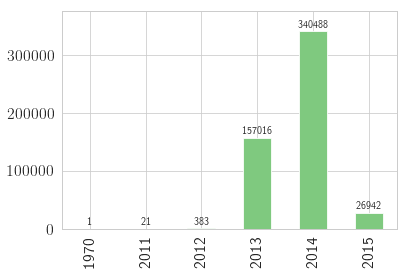

In [8]:
fig, ax = plt.subplots()
ax = df.timestamp.dt.year.value_counts().sort_index(ascending=True).plot.bar(color=colorcycle[0], ax=ax) 
countsOnBarPlot(ax) 
looseAxesLimits(ax, (0, 0, 0, 0.05))
fig.savefig("figs/uncleaned_phone_data_data_points_by_year.pdf")

Remove data preceding 2013.

In [9]:
df = df[df.timestamp.dt.year >= 2013] 

In [10]:
monthNameLookup = {1: 'Jan.', 2: 'Feb.', 3: 'Mar.', 4: 'Apr.', 5: 'May', 6: 'June',
                   7: 'July', 8: 'Aug.', 9: 'Sept.', 10: 'Oct.', 11: 'Nov.', 12: 'Dec.'}

grp = df.groupby([df.timestamp.dt.year, df.timestamp.dt.month]) 

In [11]:
# Change to to timeseries index
ddf = df.reset_index().set_index('timestamp')
ddf.index = pd.to_datetime(ddf.index)  # ensure that it's a timeseries... probably redundant

# ****************************************************************************
# *                   # Split into call and sms DataFrames                   *
# ****************************************************************************

# Call DataFrame
ddf_call = ddf.loc[ddf.comtype == 'call']  # make split
# Groupby and fix index: Yesr, Month -> timeseries
ddf_call = ddf_call.groupby([ddf_call.index.year, ddf_call.index.month]).timeint.count() 
ddf_call.index.names = ('year', 'month') 
idx_call = [dtparse(f"{year}/{month}") for (year, month) in
            zip(ddf_call.index.get_level_values(0), ddf_call.index.get_level_values(1))]
ddf_call.index = idx_call 
# Make it a DataFrame
ddf_call = pd.DataFrame(ddf_call)
ddf_call = ddf_call.rename(columns={'timeint': 'Call'})

# SMS DataFrame
ddf_sms = ddf.loc[ddf.comtype == 'sms']
# Groupby and fix index: Yesr, Month -> timeseries
ddf_sms = ddf_sms.groupby([ddf_sms.index.year, ddf_sms.index.month]).timeint.count()
ddf_sms.index.names = ('year', 'month') 
idx_sms = [dtparse(f"{year}/{month}") for (year, month) in
           zip(ddf_sms.index.get_level_values(0), ddf_sms.index.get_level_values(1))]
ddf_sms.index = idx_sms
# Make it a DataFrame
ddf_sms = pd.DataFrame(ddf_sms)
ddf_sms = ddf_sms.rename(columns={'timeint': 'SMS'})

# Join sms and call DataFrame
ddfc = ddf_call.join(ddf_sms)
del ddf_call, ddf_sms


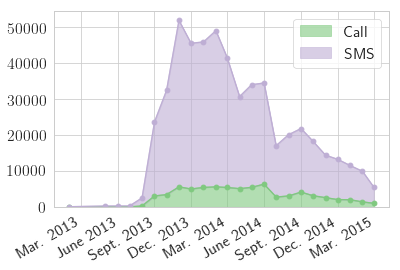

In [12]:
fig, ax = plt.subplots()
ddfc.plot.area(stacked=True, alpha=0.6, ax=ax)
fig.canvas.draw()

year, month = list(zip(*[el.get_text().split('-') for el in ax.get_xticklabels()]))
month = [monthNameLookup[int(mnt)] for mnt in month] 
xticks = [f"{month} {year}" for (year, month) in zip(year, month)]
ax.set_xticklabels(xticks); 

ddfc.Call.plot(marker='o', color=colorcycle[0], ax=ax)
ddfc.sum(axis=1).plot(marker='o', color=colorcycle[1], ax=ax)
fig.canvas.draw() 
fig.savefig("figs/cleaned_call_and_sms_data_stacked_by_month.pdf")

## Remove entries with users contacting themself

In [13]:
tmp = df.reset_index()
tmp = tmp[(tmp.user != tmp.contactedUser)]
df = tmp.set_index(['user', 'comtype'], drop=False)
del tmp

# Play with a sliding window algorithm to determine connectivity

In [14]:
df.loc[['u0001', 'u0002', 'u0003']]

user comtype                                      body  duration  hour     timeint           timestamp  weekday contactedUser
user  comtype                                                                                                                                
u0001 call     u0001    call                                       NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493
      call     u0001    call                                       NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493
      call     u0001    call                                       NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117
      call     u0001    call                                       NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493
      call     u0001    call                                       NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117
      call     u0001    call                                       NaN      20.0    14  1394806117 2014-03-14 14:08:37        4         u0117
      call     u0001    call                                       NaN      16.0    14  1394806160 2014-03-14 14:09:20        4         u0117
      call     u0001    call                                       NaN      14.0    18  1397933377 2014-04-19 18:49:37        5         u0493
      call     u0001    call                                       NaN      25.0     8  1398327318 2014-04-24 08:15:18        3         u0117
      call     u0001    call                                       NaN      28.0    13  1398607191 2014-04-27 13:59:51        6         u0117
      call     u0001    call                                       NaN      54.0    14  1398608111 2014-04-27 14:15:11        6         u0117
      call     u0001    call                                       NaN      34.0    17  1399656500 2014-05-09 17:28:20        4         u0392
      call     u0001    call                                       NaN      52.0     6  1400739965 2014-05-22 06:26:05        3         u0117
      call     u0001    call                                       NaN     130.0     6  1400740736 2014-05-22 06:38:56        3         u0117
      call     u0001    call                                       NaN      13.0    10  1400755269 2014-05-22 10:41:09        3         u0117
      call     u0001    call                                       NaN       3.0    10  1424341746 2015-02-19 10:29:06        3         u0117
      call     u0001    call                                       NaN       2.0    10  1424341756 2015-02-19 10:29:16        3         u0117
      call     u0001    call                                       NaN      35.0    15  1426261466 2015-03-13 15:44:26        4         u0117
      call     u0001    call                                       NaN       9.0    15  1426262006 2015-03-13 15:53:26        4         u0117
      call     u0001    call                                       NaN      60.0    17  1426267740 2015-03-13 17:29:00        4         u0117
      sms      u0001     sms  4c916acc6ce08fb0cecd01d6ffa9db8393b3bb83       NaN    22  1390690778 2014-01-25 22:59:38        5         u0493
      sms      u0001     sms  b0bf4e3daadbb14e0c55c306d28fe0b1286c5f65       NaN    10  1390732076 2014-01-26 10:27:56        6         u0493
      sms      u0001     sms  afb6c04a756f9d66498413195a0b551437a38334       NaN    10  1390732474 2014-01-26 10:34:34        6         u0493
      sms      u0001     sms  b5e496a6eaa67df5ed1d7302c5384ba779c584f5       NaN    10  1390732837 2014-01-26 10:40:37        6         u0493
      sms      u0001     sms  d4e359e0872642a5c33dbc842af46c70c008d757       NaN    10  1390732890 2014-01-26 10:41:30        6         u0493
      sms      u0001     sms  c8860dd1304194daae8027aed488c3d85441f518       NaN    15  1390749221 2014-01-26 15:13:41        6         u0493
      sms      u0001     sms  8757b40de4

# Turn data into a Networkx graph

1. Split the data into call and SMS data.
2. Create directional weighted graphs from both.
3. Convert call graph to undirected graph, not requiering a mutual relationship for a link to exist.
4. Convert sms graph to directed graph, requiering a mutual relationship for a link to exist.
5. Combine in a single weighted, undirected graph.

In [15]:
# g = userDf2nxGraph(df, graphtype=nx.DiGraph)
cdf = df.xs('call', level=1)
cdf = cdf.reset_index(drop=True).set_index(['user', 'comtype'], drop=False)
gc = userDf2nxGraph(cdf, graphtype=nx.DiGraph)
sdf = df.xs('sms', level=1)
sdf = sdf.reset_index(drop=True).set_index(['user', 'comtype'], drop=False)
gs = userDf2nxGraph(sdf, graphtype=nx.DiGraph)

In [16]:
g = gc.to_undirected(reciprocal=True) 
g.add_nodes_from(gs.nodes()) 
g.add_weighted_edges_from(gs.to_undirected(reciprocal=True).edges(data='weight'))

Ensure that the graph contains the correct number of nodes

In [17]:
g = graph.nxDiGraph2Graph(gc, agg=lambda x: sum(x))

In [18]:
list(nx.isolates(g))

[]

In [19]:
len(g.degree())

774

## Analyse the graph

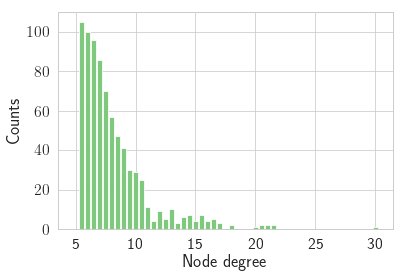

In [20]:
fig, ax = plt.subplots()
cnt = Counter(el[1] for el in g.degree())
x, y = list(zip(*((i, cnt[i]) for i in range(max(cnt)+1))))
ax.bar(x, y)
ax.set_xlabel('Node degree')
ax.set_ylabel('Counts')
# countsOnBarPlot(ax) 
ax.set_xticklabels(np.arange(0, 51, 5))
fig.savefig("figs/degree_of_nodes.pdf")

There's a single person with _a lot_ of connections... look into him.

In [21]:
manyfriends_node = [n for (n, d) in g.degree() if d == max(cnt)][0] 

tmp = g[manyfriends_node] 
tmp

AtlasView({'u0047': {'weight': 3}, 'u0073': {'weight': 103}, 'u0108': {'weight': 2}, 'u0120': {'weight': 8}, 'u0122': {'weight': 1}, 'u0128': {'weight': 39}, 'u0146': {'weight': 5}, 'u0150': {'weight': 13}, 'u0211': {'weight': 24}, 'u0226': {'weight': 24}, 'u0287': {'weight': 135}, 'u0304': {'weight': 1}, 'u0311': {'weight': 2}, 'u0314': {'weight': 3}, 'u0318': {'weight': 6}, 'u0721': {'weight': 16}, 'u0796': {'weight': 21}, 'u0818': {'weight': 14}, 'u0477': {'weight': 30}, 'u0392': {'weight': 17}, 'u0444': {'weight': 10}, 'u0758': {'weight': 13}, 'u1008': {'weight': 12}, 'u0808': {'weight': 8}, 'u0951': {'weight': 10}, 'u0607': {'weight': 5}, 'u0463': {'weight': 5}, 'u0973': {'weight': 4}, 'u0583': {'weight': 4}, 'u0348': {'weight': 6}, 'u0491': {'weight': 6}, 'u0441': {'weight': 4}, 'u0920': {'weight': 2}, 'u0981': {'weight': 8}, 'u0930': {'weight': 2}, 'u0844': {'weight': 4}, 'u0783': {'weight': 2}, 'u1054': {'weight': 4}, 'u0719': {'weight': 4}, 'u0400': {'weight': 1}, 'u0655': {'w

Remove edges with a weight below 2.

In [22]:
toRemove = [frozenset(edge) for edge, weight in nx.get_edge_attributes(g, 'weight').items() if weight < 2]

In [23]:
g.remove_edges_from((tuple(edge) for edge in toRemove))

In [24]:
len(g.degree())

774

In [25]:
g.remove_nodes_from(list(nx.isolates(g)))

In [26]:
len(g.degree())

743

Text(0,0.5,'Counts')

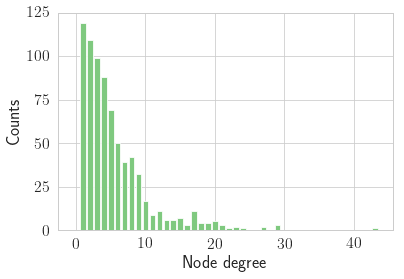

In [27]:
fig, ax = plt.subplots()
cnt = Counter(el[1] for el in g.degree())
x, y = list(zip(*((i, cnt[i]) for i in range(max(cnt)+1))))
ax.bar(x, y)
ax.set_xlabel('Node degree')
ax.set_ylabel('Counts')

# countsOnBarPlot(ax) 

# Clique detection

Could be used for analysis of a larger network.

Notice that requering mutual relations between nodes removes the 7-cliques.

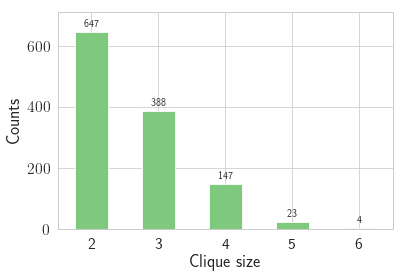

In [28]:
cliqueDf = pd.DataFrame(nx.clique.find_cliques_recursive(g))

cliqueDf['cliqueSize'] = cliqueDf.count(axis=1)
cliqueDf = cliqueDf.sort_values('cliqueSize', ascending=False)
cliqueDf = cliqueDf.reset_index(drop=True) 

fig, ax = plt.subplots()
cliqueDf.cliqueSize.value_counts().sort_index().plot.bar(rot=0, color=colorcycle[0], ax=ax) 
ax.set_xlabel('Clique size') 
ax.set_ylabel('Counts') 
countsOnBarPlot(ax)

cliqueDf = cliqueDf[cliqueDf.cliqueSize > 2]

looseAxesLimits(ax, (0, 0, 0, 0.05))
fig.savefig("figs/clique_size_after_graph_cleaning.pdf")

# Community detection

Find communities consisting of 5-cliques with a 4 degree connection between the cliques.

[From Documentation](http://networkx.readthedocs.io/en/latest/reference/generated/networkx.algorithms.community.kclique.k_clique_communities.html#networkx.algorithms.community.kclique.k_clique_communities):

> Find $k$-clique communities in graph using the percolation method.
> 
> A $k$-clique community is the union of all cliques of size $k$ that can be reached through adjacent (sharing $k-1$ nodes) $k$-cliques.

{'vertex_size': 25, 'vertex_color': 'rgb(127, 201, 127)', 'vertex_label_color': 'rgb(0, 11, 79)', 'edge_color': 'rgb(0.2, 0.2, 0.2, 0.35)', 'nodeLabels': ['u0818', 'u0758', 'u0108', 'u0228', 'u0150', 'u0477', 'u0489', 'u0444', 'u0441', 'u0287', 'u0128', 'u0463', 'u0813', 'u0324', 'u0491', 'u0951', 'u0154'], 'edge_width': [1.5104166666666665, 1.1041666666666667, 1.0729166666666667, 1.1458333333333333, 1.5104166666666665, 1.3854166666666667, 1.0625, 1.125, 1.0208333333333333, 1.0208333333333333, 1.1354166666666667, 2.302083333333333, 1.1354166666666667, 1.1354166666666667, 1.1770833333333333, 1.125, 1.4791666666666667, 1.3854166666666667, 1.5625, 1.0208333333333333, 1.0208333333333333, 1.0625, 1.0208333333333333, 1.09375, 1.2083333333333333, 1.03125, 1.1458333333333333, 1.03125, 1.1354166666666667, 1.0625, 1.0625, 1.1979166666666667, 1.2291666666666667, 1.09375, 2.010416666666667, 1.3125, 1.1354166666666667, 1.125, 1.0729166666666667, 1.1875, 1.0208333333333333, 1.0416666666666667, 1.062

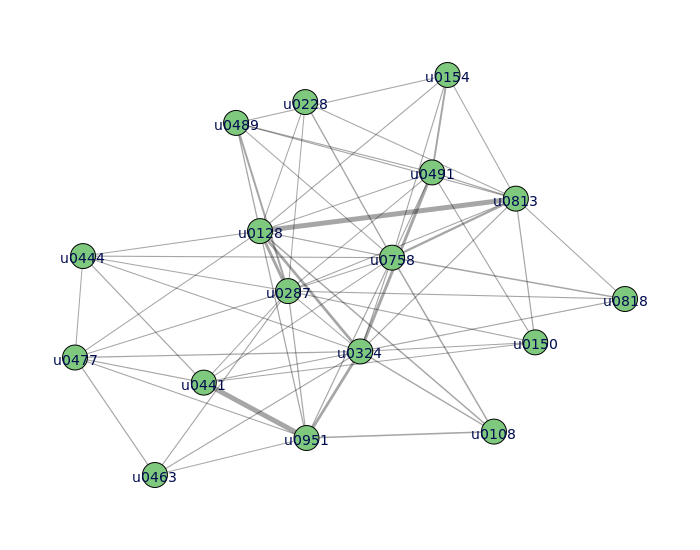

users,0,1,2,3,4,...,13,14,15,16,communitySize
communityNumber,,,,,,,,,,,
0,u0758,u0441,u0287,u0463,u0324,...,u0444,u0128,u0813,u0108,17
1,u0033,u0314,u0396,u0749,u0655,...,None,None,None,None,6
2,u0211,u0930,u0226,u0324,u0073,...,None,None,None,None,6
3,u0256,u0140,u0885,u0981,u0820,...,None,None,None,None,5
4,u0146,u0392,u0324,u0211,u0073,...,None,None,None,None,5


In [44]:
cliqueLst = [lst.dropna().tolist() for (_, lst) in cliqueDf.drop('cliqueSize', axis=1).iterrows()]
kcDf = pd.DataFrame(sorted(nx.algorithms.community.k_clique_communities(g, 5, cliques=cliqueLst),
                           key=lambda x: len(x), reverse=True))
kcDf.columns.name = 'users'
kcDf.index.name = 'communityNumber'

gsc = g.subgraph(kcDf.iloc[0])
#nxQuickDraw(gsc)
disp(igdraw(gsc, nodeLabels=True, filename="figs/community_size_17.pdf"))
# disp(igdraw(networkx2igraph(gsc)))

kcDf['communitySize'] = kcDf.count(axis=1)
disp(kcDf.head()) 

## Choose a clique with 5 users and make a subgraph 

In [45]:
df.head() 

user comtype body  duration  hour     timeint           timestamp  weekday contactedUser
user  comtype                                                                                           
u0001 call     u0001    call  NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493
      call     u0001    call  NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493
      call     u0001    call  NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117
      call     u0001    call  NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493
      call     u0001    call  NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117

Chosen users:
u0324
u0287
u0758
u0441
u0951
{'plotSettings': {'with_labels': True}, 'vertex_size': 25, 'vertex_color': 'rgb(127, 201, 127)', 'vertex_label_color': 'rgb(0, 11, 79)', 'edge_color': 'rgb(0.2, 0.2, 0.2, 0.35)', 'nodeLabels': [], 'edge_width': [1.0479041916167664, 1.311377245508982, 1.311377245508982, 1.2874251497005988, 1.0479041916167664, 5.0, 1.095808383233533, 1.5508982035928143, 1.311377245508982, 5.0]}


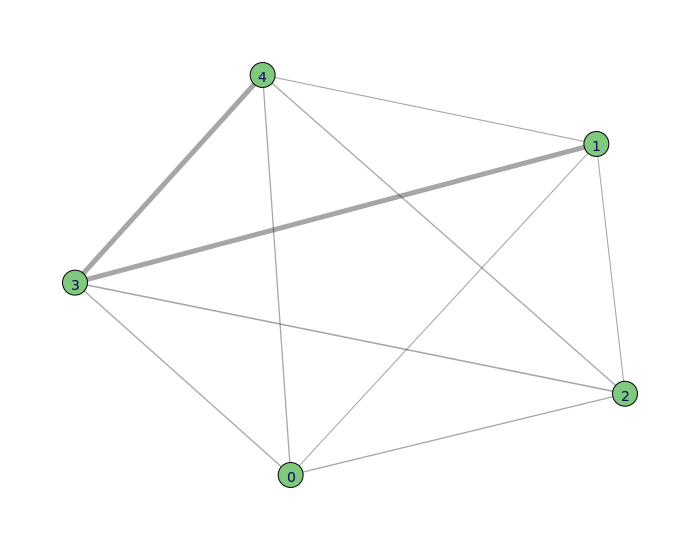

In [49]:
chosenUserLst = cliqueDf[cliqueDf.cliqueSize == 5].drop('cliqueSize', axis=1).iloc[1].dropna().tolist()
print("Chosen users:", *chosenUserLst, sep='\n') 
gs = g.subgraph(chosenUserLst)
igdraw(gs, plotSettings={'with_labels': True})

In [50]:
df.head() 

user comtype body  duration  hour     timeint           timestamp  weekday contactedUser
user  comtype                                                                                           
u0001 call     u0001    call  NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493
      call     u0001    call  NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493
      call     u0001    call  NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117
      call     u0001    call  NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493
      call     u0001    call  NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117

Cut data to exclude time with low activity

Text(0,0.5,'Communication events')

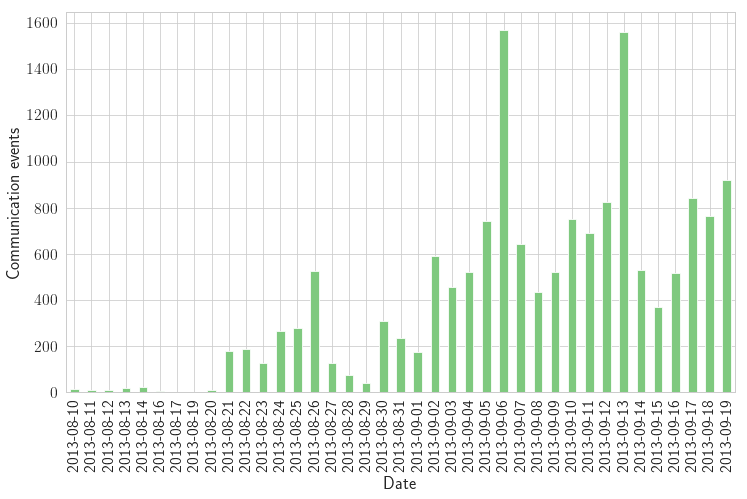

In [52]:
# tmp = df[(df.timestamp > '20130810' ) & (df.timestamp < '20130920')]
# tmp = tmp.groupby([tmp.timestamp.dt.month, tmp.timestamp.dt.day]).timeint.count()
# ax = tmp.plot.bar() 

#       Cut DataFrame to chosen time interval                           Count on the date                Sort by date and plot it
ax = df[(df.timestamp > '2013-08-10' ) & (df.timestamp < '2013-09-20')].timestamp.dt.date.value_counts().sort_index().plot.bar(color=colorcycle[0])
ax.set_xlabel('Date')
ax.set_ylabel('Communication events') 

Seems like the useage spiked around 21/08/2013. 

Text(0.5,1,'After date cropping')

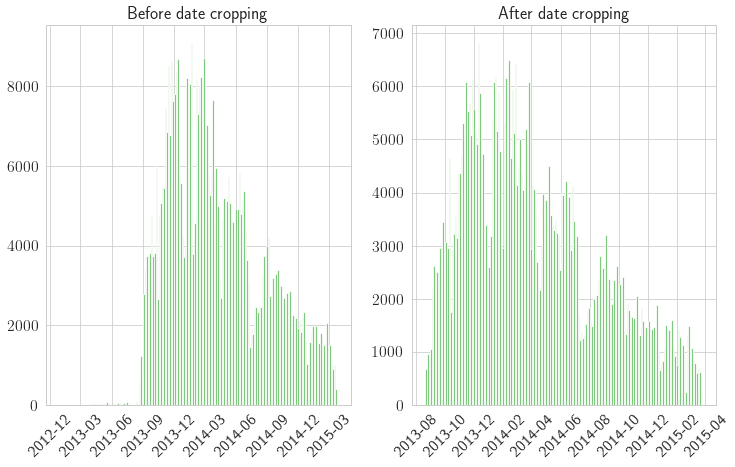

In [53]:
fig, (ax0, ax1) = plt.subplots(1, 2)
df.timestamp.hist(bins=180, ax=ax0, xrot=45)  
ax0.set_title('Before date cropping')
df = df[df.timestamp > '2013-08-21']
df.timestamp.hist(bins=180, ax=ax1, xrot=45) 
ax1.set_title('After date cropping')

### Determine start time offset for the binning 

Find the first occuring communication...

In [54]:
t0 = df.timestamp.min()
t0

Timestamp('2013-08-21 10:40:29')

…and choose the corresponding day...

In [55]:
t0d = pd.Timestamp(t0.date())
t0d

Timestamp('2013-08-21 00:00:00')

Since the timeint is in seconds, but Pandas keeps it's records in nanoseconds, the integer representation of the date needs to be divided by 1e9.

To check that this is indeed true, compare the values of the integer casted `t0` to the timeint for the corresponding row:

In [56]:
np.int64(t0.value // 1e9) == df.loc[df.timestamp.idxmin()].timeint.values[0]

True

Since it was true, use the following for the bin time start

In [57]:
t0d = np.int64(t0d.value // 1e9)
t0 = np.int64(t0.value // 1e9) 
t0d

1377043200

Binning is simply performed by integer division with a suiting bin width.
I choose 8 hours:

In [58]:
bw8h = 60**2*8
df['tbin'] = (df.timeint - t0d) // bw8h
df.head()

user comtype body  duration  hour     timeint           timestamp  weekday contactedUser  tbin
user  comtype                                                                                                 
u0001 call     u0001    call  NaN       0.0     1  1390698006 2014-01-26 01:00:06        6         u0493   474
      call     u0001    call  NaN       0.0    14  1391176805 2014-01-31 14:00:05        4         u0493   490
      call     u0001    call  NaN      29.0    14  1391782631 2014-02-07 14:17:11        4         u0117   511
      call     u0001    call  NaN      22.0    14  1391782712 2014-02-07 14:18:32        4         u0493   511
      call     u0001    call  NaN       3.0    14  1394805935 2014-03-14 14:05:35        4         u0117   616

In [59]:
%whos DataFrame

Variable   Type         Data/Info
---------------------------------
cdf        DataFrame                    user comt<...>n[71097 rows x 9 columns]
cliqueDf   DataFrame             0      1      2 <...>n\n[562 rows x 7 columns]
ddf        DataFrame                          use<...>[524446 rows x 8 columns]
ddfc       DataFrame                Call    SMS\n<...>\n2015-03-01   999   4521
df         DataFrame                    user comt<...>508466 rows x 10 columns]
kcDf       DataFrame    users                0   <...>n\n[11 rows x 18 columns]
sdf        DataFrame                    user comt<...>[438512 rows x 9 columns]


Sample one clique of each size

In [60]:
ccdfs = pd.DataFrame([cliqueDf[cliqueDf.cliqueSize == i].iloc[0] for i in cliqueDf.cliqueSize.unique()])
ccdfs

,0,1,2,3,4,5,cliqueSize
0,u0396,u0749,u0314,u0033,u0655,u0128,6
4,u0324,u0287,u0477,u0951,u0128,None,5
27,u0882,u0284,u0947,u0476,None,None,4
174,u0786,u0233,u0583,None,None,None,3


In [61]:
ccdf = cliqueDf[cliqueDf.cliqueSize == 5].iloc[:8] 
ccdf

,0,1,2,3,4,5,cliqueSize
4,u0324,u0287,u0477,u0951,u0128,None,5
5,u0324,u0287,u0758,u0441,u0951,None,5
6,u0324,u0287,u0477,u0951,u0441,None,5
7,u0324,u0287,u0477,u0444,u0128,None,5
8,u0324,u0287,u0758,u0441,u0444,None,5
9,u0324,u0226,u0930,u0073,u0211,None,5
10,u0324,u0226,u0930,u0073,u0607,None,5
11,u0324,u0287,u0477,u0951,u0463,None,5


In [62]:
dct = communityDf2Pca(df, ccdfs, 'tbin', graphtype=nx.DiGraph) 

In [63]:
dct

{('u0324',
  'u0287',
  'u0477',
  'u0951',
  'u0128'): PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 ('u0396',
  'u0749',
  'u0314',
  'u0033',
  'u0655',
  'u0128'): PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 ('u0786',
  'u0233',
  'u0583'): PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 ('u0882',
  'u0284',
  'u0947',
  'u0476'): PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False)}

In [64]:
key = list(dct.keys())[0]
pca = dct[key]
disp(key, pca, pca.components_.shape, pca.components_[:, :3])  # three most dominant components

('u0396', 'u0749', 'u0314', 'u0033', 'u0655', 'u0128')

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(36, 1741)

array([[-1.03328664e-16,  8.52681362e-02,  3.30349240e-02],
       [ 1.13331875e-15, -2.57563464e-02,  7.03167383e-02],
       [-5.66195125e-16, -8.31656508e-03,  5.65326127e-03],
       [-7.39356175e-16, -3.56440452e-03,  7.23742108e-02],
       [ 7.48478714e-17,  3.57830682e-03,  2.66633882e-02],
       [-5.43645224e-16, -6.69179294e-03,  3.10636827e-03],
       [-8.51936214e-16, -1.28713492e-03, -1.27488970e-02],
       [-8.18911915e-17, -7.63635549e-04, -9.61270334e-04],
       [ 6.42721628e-16, -9.11540533e-04, -1.06835378e-03],
       [-4.23141405e-16, -2.11384168e-03,  1.33157474e-03],
       [-5.12897494e-16, -1.63094705e-04,  5.99294266e-03],
       [ 7.65180823e-16,  2.91000260e-03, -2.98964758e-02],
       [-5.60366953e-16, -8.89968408e-04, -2.39217473e-03],
       [ 5.57474617e-16, -4.09265351e-04, -4.73024768e-03],
       [-1.03354193e-15, -1.42445589e-03, -4.15427071e-03],
       [-1.44141638e-15,  5.94622008e-05,  5.15160780e-04],
       [ 4.41392689e-16,  2.85746643e-03

In [65]:
def usernames2nameMatrix(usernameLst):
    usernameLst = list(usernameLst) 
    n = len(usernameLst)
    uArr = np.NaN*np.ones(shape=(n, n), dtype=object)
    for i, ui in enumerate(usernameLst):
        for j, uj in enumerate(usernameLst):
            if i != j:
                uArr[i, j] = (ui, uj)
    return uArr

for _, row in ccdfs.iterrows():
    key = row[:-1].dropna().tolist()
    print(key)
    print('\n\n')
    print(usernames2nameMatrix(key))
    print('\n\n\n---------------------------------------------------\n\n\n')

['u0396', 'u0749', 'u0314', 'u0033', 'u0655', 'u0128']



[[nan ('u0396', 'u0749') ('u0396', 'u0314') ('u0396', 'u0033') ('u0396', 'u0655') ('u0396', 'u0128')]
 [('u0749', 'u0396') nan ('u0749', 'u0314') ('u0749', 'u0033') ('u0749', 'u0655') ('u0749', 'u0128')]
 [('u0314', 'u0396') ('u0314', 'u0749') nan ('u0314', 'u0033') ('u0314', 'u0655') ('u0314', 'u0128')]
 [('u0033', 'u0396') ('u0033', 'u0749') ('u0033', 'u0314') nan ('u0033', 'u0655') ('u0033', 'u0128')]
 [('u0655', 'u0396') ('u0655', 'u0749') ('u0655', 'u0314') ('u0655', 'u0033') nan ('u0655', 'u0128')]
 [('u0128', 'u0396') ('u0128', 'u0749') ('u0128', 'u0314') ('u0128', 'u0033') ('u0128', 'u0655') nan]]



---------------------------------------------------



['u0324', 'u0287', 'u0477', 'u0951', 'u0128']



[[nan ('u0324', 'u0287') ('u0324', 'u0477') ('u0324', 'u0951') ('u0324', 'u0128')]
 [('u0287', 'u0324') nan ('u0287', 'u0477') ('u0287', 'u0951') ('u0287', 'u0128')]
 [('u0477', 'u0324') ('u0477', 'u0287') nan ('u0477', 'u

{'vertex_size': 25, 'vertex_color': 'rgb(127, 201, 127)', 'vertex_label_color': 'rgb(0, 11, 79)', 'edge_color': 'rgb(0.2, 0.2, 0.2, 0.35)', 'nodeLabels': ['u0758', 'u0441', 'u0287', 'u0324', 'u0951'], 'edge_width': [1.0479041916167664, 1.311377245508982, 1.311377245508982, 1.2874251497005988, 1.0479041916167664, 5.0, 1.095808383233533, 1.5508982035928143, 1.311377245508982, 5.0]}


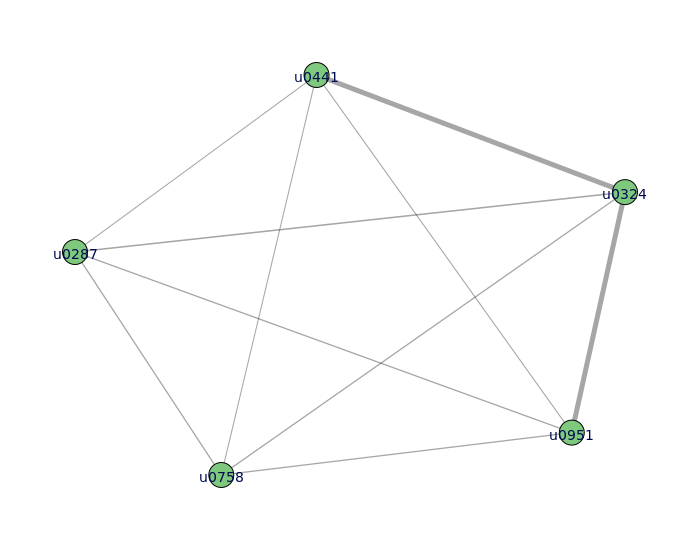

In [76]:
igdraw(gs, nodeLabels=True)

In [77]:
list(gs.nodes())

['u0758', 'u0441', 'u0287', 'u0324', 'u0951']

In [78]:
nx.get_edge_attributes(gs, 'weight')

{('u0287', 'u0324'): 135,
 ('u0287', 'u0951'): 46,
 ('u0324', 'u0951'): 10,
 ('u0441', 'u0287'): 167,
 ('u0441', 'u0324'): 4,
 ('u0441', 'u0951'): 23,
 ('u0758', 'u0287'): 13,
 ('u0758', 'u0324'): 13,
 ('u0758', 'u0441'): 2,
 ('u0758', 'u0951'): 12}

In [79]:
adjmat = nx.adjacency_matrix(gs).todense() 
adjmat

matrix([[  0,   2,  13,  13,  12],
        [  2,   0, 167,   4,  23],
        [ 13, 167,   0, 135,  46],
        [ 13,   4, 135,   0,  10],
        [ 12,  23,  46,  10,   0]], dtype=int64)

In [80]:
dfg = pd.DataFrame(nx.adjacency_matrix(gs).todense(), columns=gs.nodes(), index=gs.nodes())
dfg

,u0758,u0441,u0287,u0324,u0951
u0758,0,2,13,13,12
u0441,2,0,167,4,23
u0287,13,167,0,135,46
u0324,13,4,135,0,10
u0951,12,23,46,10,0


In [81]:
dfg2 = pd.DataFrame(np.zeros((5, 5), dtype=int), columns=gs.nodes(), index=gs.nodes())
for ed, wt in nx.get_edge_attributes(gs, 'weight').items():
    dfg2.loc[ed[0], ed[1]] = wt
    dfg2.loc[ed[1], ed[0]] = wt
dfg2

,u0758,u0441,u0287,u0324,u0951
u0758,0,2,13,13,12
u0441,2,0,167,4,23
u0287,13,167,0,135,46
u0324,13,4,135,0,10
u0951,12,23,46,10,0


In [82]:
(dfg2 == dfg).values.all() 

True

In [83]:
upperTril2adjMat(np.squeeze(np.array(adjMatUpper2array(adjmat))))

array([[  0,   2,  13,  13,  12],
       [  2,   0, 167,   4,  23],
       [ 13, 167,   0, 135,  46],
       [ 13,   4, 135,   0,  10],
       [ 12,  23,  46,  10,   0]], dtype=int64)

In [84]:
upperTril2adjMat(adjMatUpper2array(usernames2nameMatrix(gs.nodes())))

array([[None, ('u0758', 'u0441'), ('u0758', 'u0287'), ('u0758', 'u0324'), ('u0758', 'u0951')],
       [('u0758', 'u0441'), None, ('u0441', 'u0287'), ('u0441', 'u0324'), ('u0441', 'u0951')],
       [('u0758', 'u0287'), ('u0441', 'u0287'), None, ('u0287', 'u0324'), ('u0287', 'u0951')],
       [('u0758', 'u0324'), ('u0441', 'u0324'), ('u0287', 'u0324'), None, ('u0324', 'u0951')],
       [('u0758', 'u0951'), ('u0441', 'u0951'), ('u0287', 'u0951'), ('u0324', 'u0951'), None]], dtype=object)

In [85]:
list(gs.edges())

[('u0758', 'u0287'),
 ('u0758', 'u0324'),
 ('u0758', 'u0441'),
 ('u0758', 'u0951'),
 ('u0441', 'u0287'),
 ('u0441', 'u0324'),
 ('u0441', 'u0951'),
 ('u0287', 'u0324'),
 ('u0287', 'u0951'),
 ('u0324', 'u0951')]

In [86]:
# evr = pca.explained_variance_ratio_
# n = (np.cumsum(evr) <= evr.sum()*0.98).sum()  # number of vectors need for 98 % explanation of variance (?)
# firstN = np.abs(pca.components_[:, :n])
# 
# fig, ax = plt.subplots()
# pc = ax.pcolorfast(pca.components_[:, :n], cmap='RdBu_r', vmin=-np.abs(firstN).max(), vmax=np.abs(firstN).max())
# fig.colorbar(pc) 
# 
# firstN += firstN.min()
# firstN[firstN < 1e-6] = 0.0
# firstN /= firstN.sum()
# firstN *= n
# graphLst = [nx.from_numpy_matrix(upperTril2adjMat(firstN[:, i])) for i in range(n)] 
# 
# layout = nx.drawing.layout.circular_layout(graphLst[0])
# 
# # weighFunc = lambda w: (2*w)**(1.5) + 1
# weighFunc = lambda w: 5*w + 0.5
# for i in range(n):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     edgeLabels = {edge: '{:.0f}'.format(np.round(1000*weight)) for (edge, weight) in
#                   nx.get_edge_attributes(graphLst[i], 'weight').items()}
#     drawWeightedGraph(graphLst[i], ax=ax, layout=layout, normailzeWeights=False, weightFunc=weighFunc,
#                       nodeLabels=True, edgeLabels=edgeLabels)
#     fig.suptitle(f'Vector {i+1}/{n}') 
# 
# fig, axi = plt.subplots(2, 1)
# for ax, n, lbl in zip(axi, [1, 6], ['', ' (smoothed)']):
#     ax.plot(np.convolve(np.ones(n)/n, pca.norm_mean, 'same'), label='norm_mean' + lbl, color='#20a365')
#     ax.plot(np.convolve(np.ones(n)/n, pca.norm_std, 'same'), label='norm_std' + lbl, color='#ea8a3f')
#     ax.legend(loc='best')
# 
# fig, axi = plt.subplots(2, 1)
# for ax, n, lbl in zip(axi, [1, 6], ['', ' (smoothed)']):
#     ax.plot(np.convolve(np.ones(n)/n, pca.norm_mean, 'same'), label='norm_mean' + lbl, color='#20a365')
#     ax.plot(np.convolve(np.ones(n)/n, pca.norm_std, 'same'), label='norm_std' + lbl, color='#ea8a3f')
#     ax.legend(loc='best')


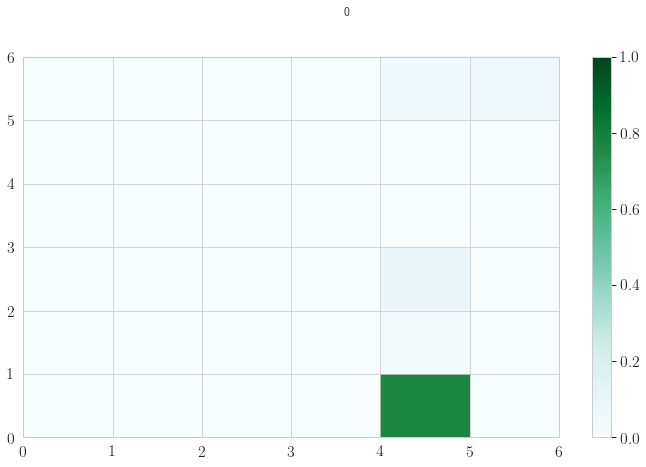

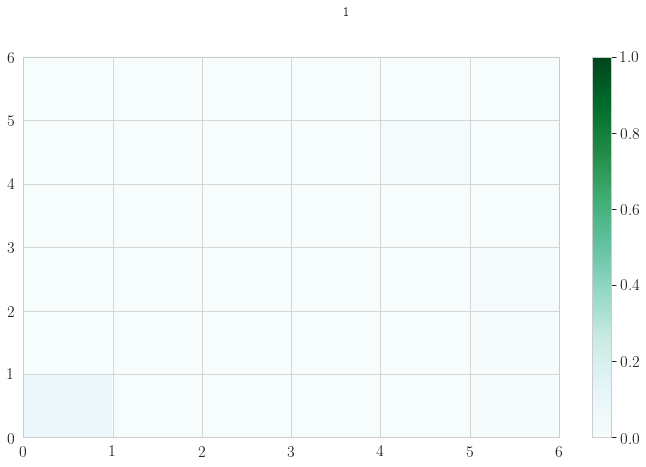

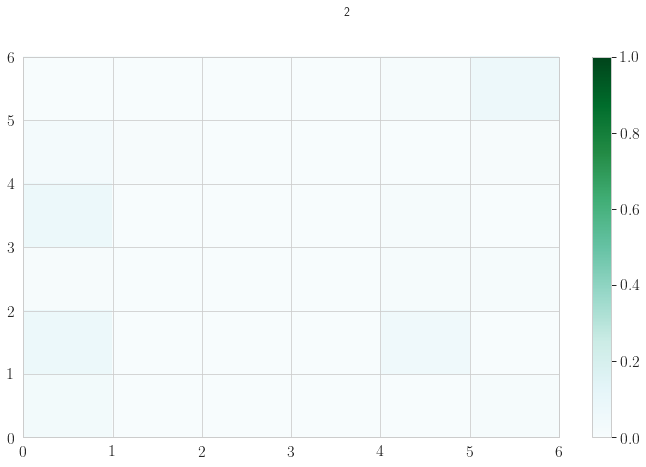

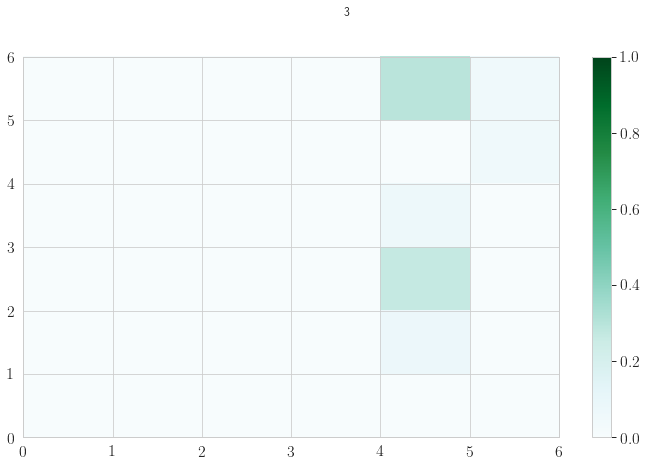

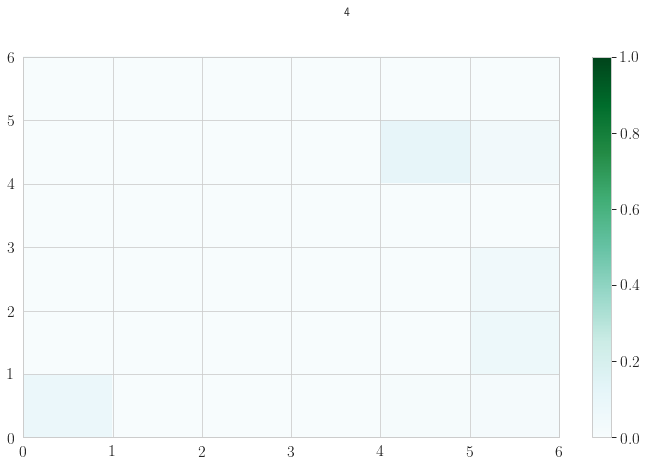

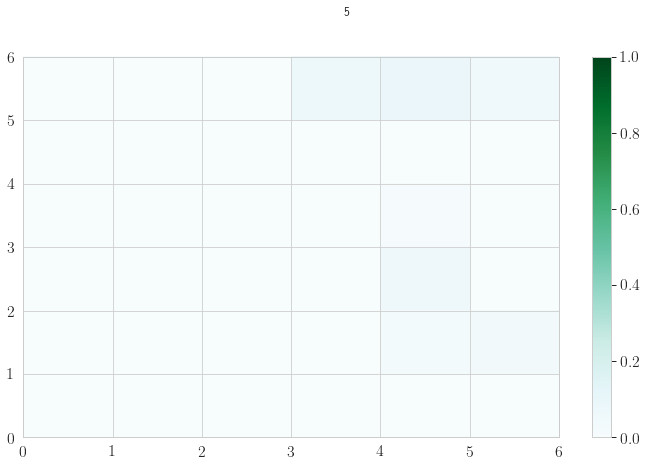

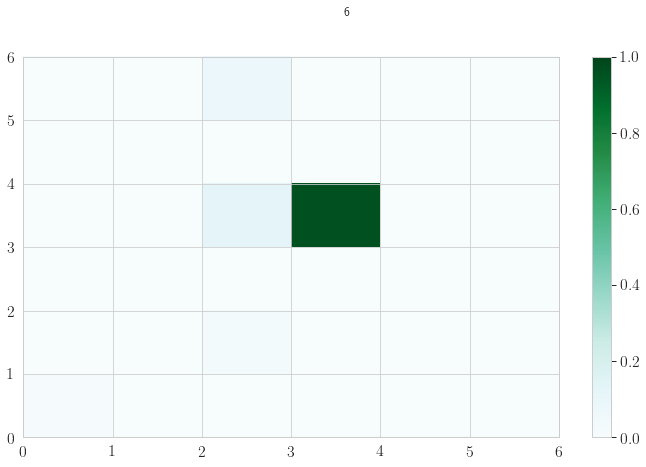

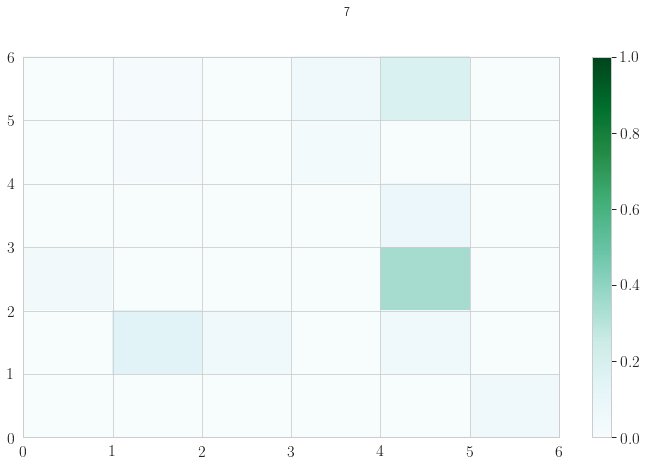

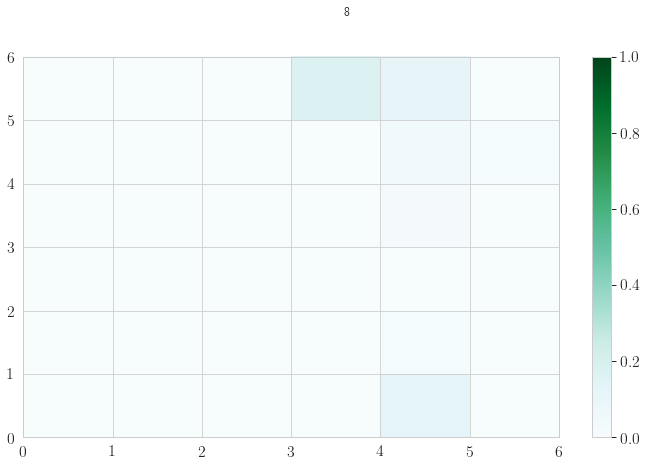

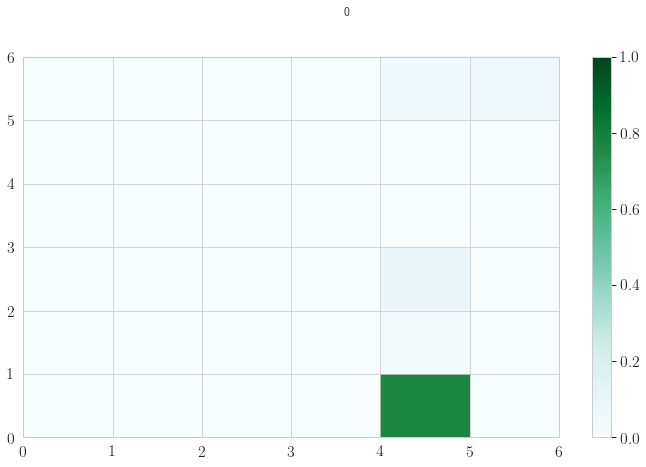

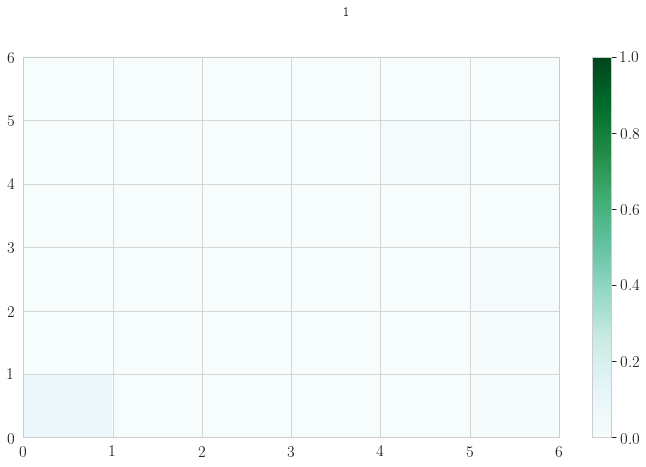

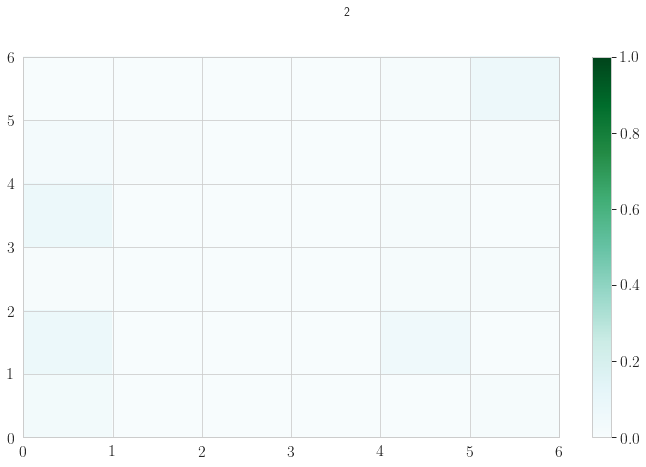

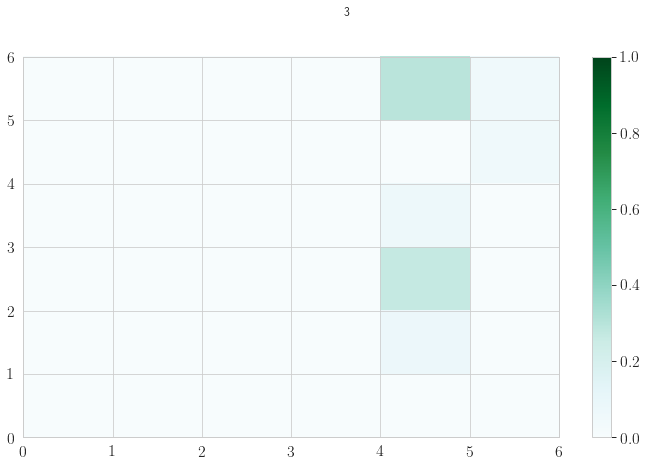

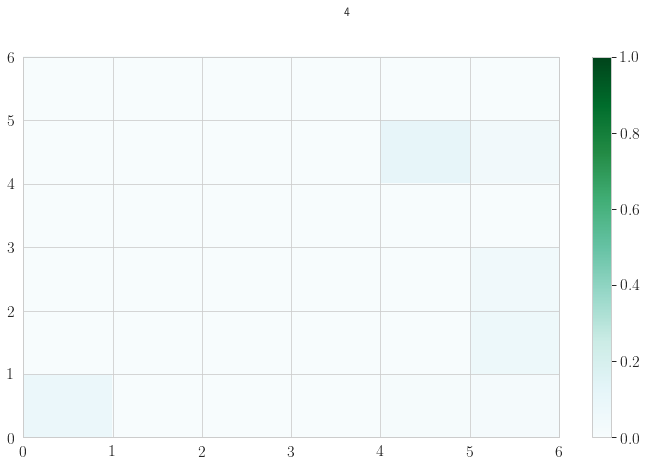

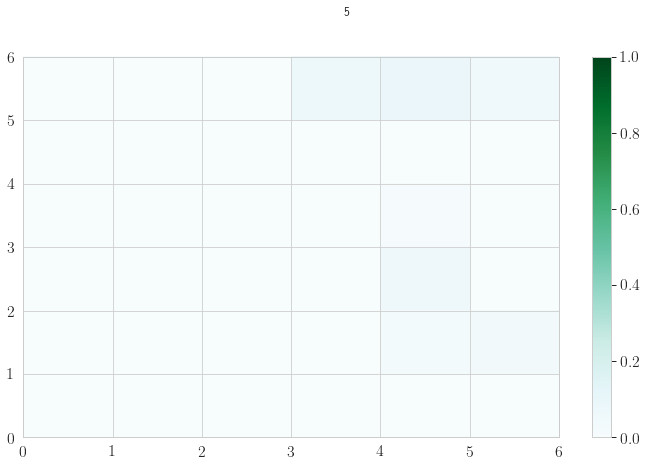

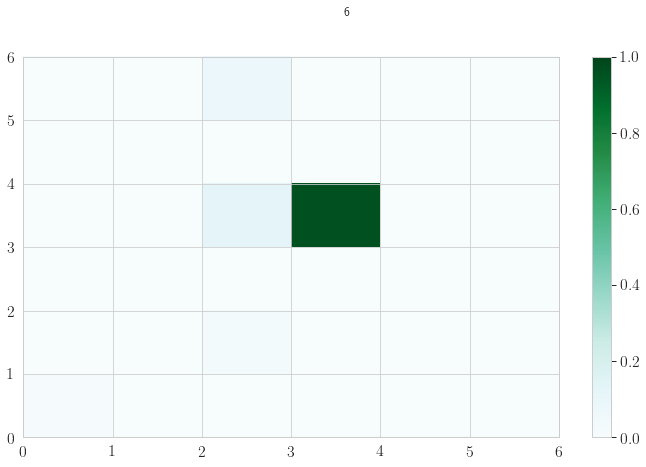

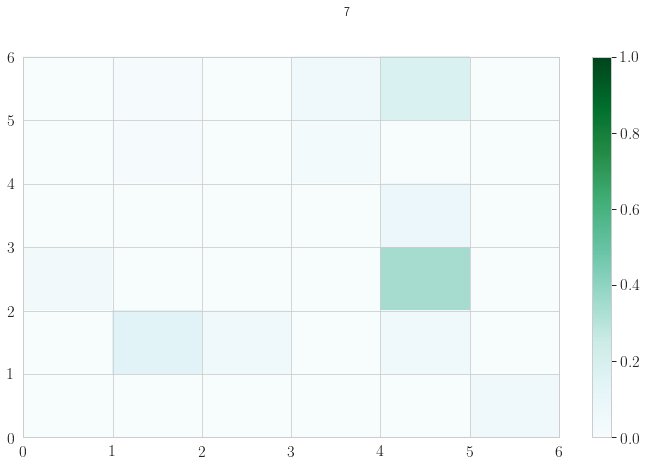

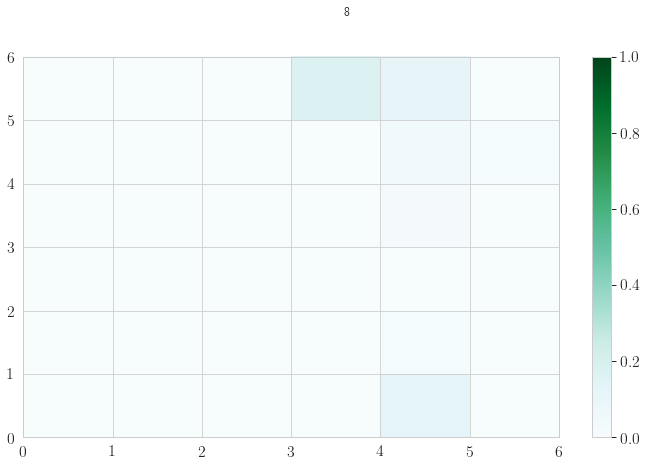

In [87]:
explVar = 0
for i in range(pca.explained_variance_ratio_.size):
    explVar += pca.explained_variance_ratio_[i]
    if explVar > 0.9:
        break
    adjmat = vec2squareMat(pca.components_[:,i]) 
    adjmat[adjmat < 1e-6] = 0.0
    fig, ax = plt.subplots()
    p = ax.pcolorfast(adjmat, vmin=0, vmax=1, cmap=mpl.cm.BuGn)
    fig.colorbar(p)
    fig.suptitle(i)
    disp(fig)

### 0

{'vertex_size': 25, 'vertex_color': 'rgb(127, 201, 127)', 'vertex_label_color': 'rgb(0, 11, 79)', 'edge_color': 'rgb(0.2, 0.2, 0.2, 0.35)', 'nodeLabels': [0, 1, 2, 3, 4, 5], 'edge_width': [5.0, 1.1695316344957356, 1.4733185899431345, 5.0, 1.1695316344957356]}


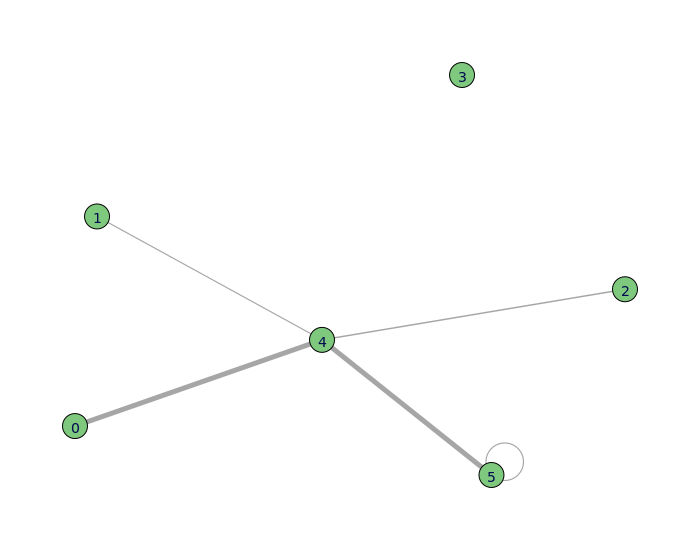

### 1

{'vertex_size': 25, 'vertex_color': 'rgb(127, 201, 127)', 'vertex_label_color': 'rgb(0, 11, 79)', 'edge_color': 'rgb(0.2, 0.2, 0.2, 0.35)', 'nodeLabels': [0, 1, 2, 3, 4, 5], 'edge_width': [5.0, 1.1678613833877682, 1.3209842673996985, 1.1365106702187753, 1.0156791024843663, 1.1340461539061188, 1.6023998772968708, 1.0156791024843663, 1.0184278889196148]}


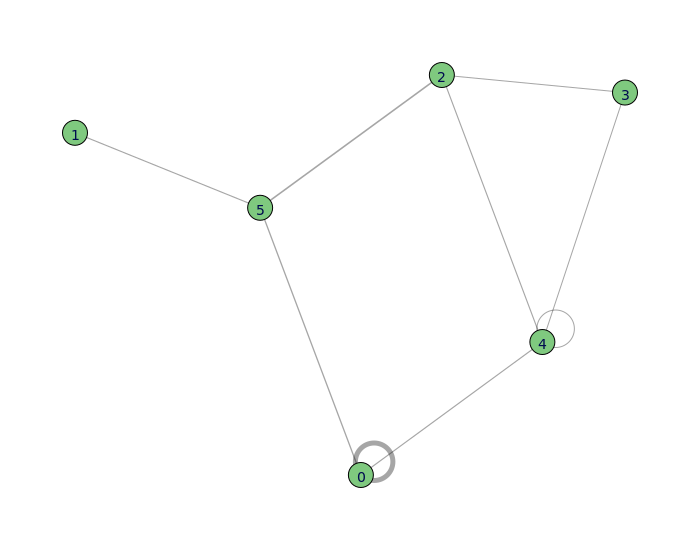

### 2

{'vertex_size': 25, 'vertex_color': 'rgb(127, 201, 127)', 'vertex_label_color': 'rgb(0, 11, 79)', 'edge_color': 'rgb(0.2, 0.2, 0.2, 0.35)', 'nodeLabels': [0, 1, 2, 3, 4, 5], 'edge_width': [2.8257842734745915, 4.886286980577491, 1.3124461715045135, 5.0, 2.4736402867375347, 1.1716837108261011, 4.886286980577491, 1.073593879496399, 1.3312197866048452, 1.3124461715045135, 1.0284720634142053, 1.1437865978254131, 1.0425383128789667, 5.0, 1.073593879496399]}


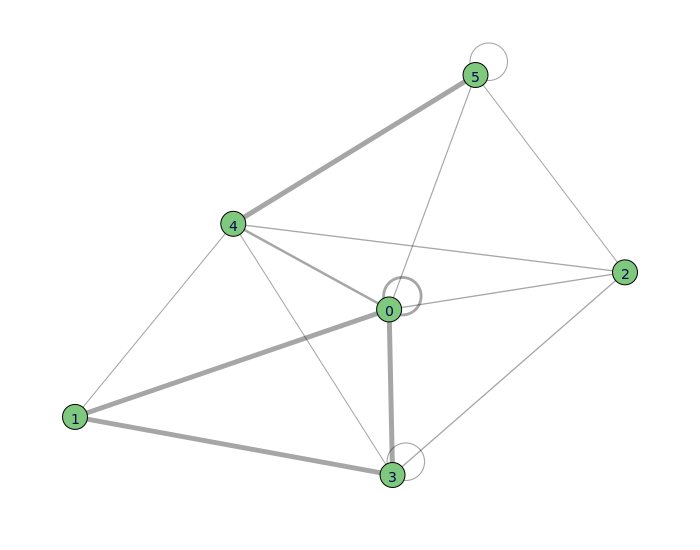

### 3

{'vertex_size': 25, 'vertex_color': 'rgb(127, 201, 127)', 'vertex_label_color': 'rgb(0, 11, 79)', 'edge_color': 'rgb(0.2, 0.2, 0.2, 0.35)', 'nodeLabels': [0, 1, 2, 3, 4, 5], 'edge_width': [2.1285263632443248, 5.0, 2.0099373468520074, 2.1285263632443248, 5.0]}


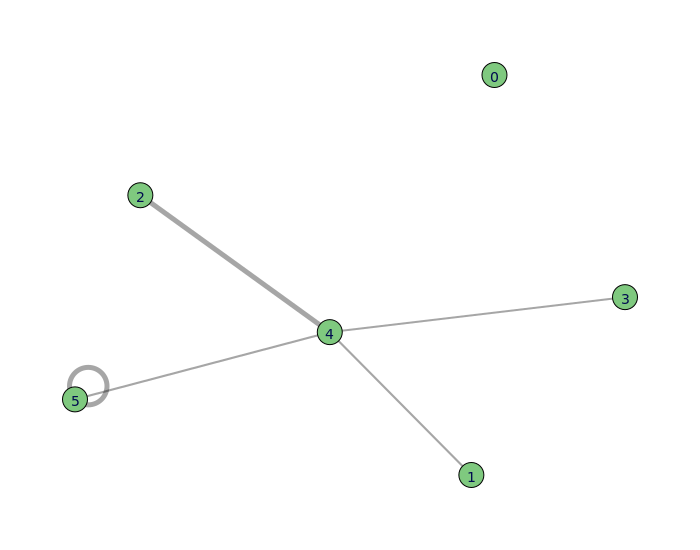

### 4

{'vertex_size': 25, 'vertex_color': 'rgb(127, 201, 127)', 'vertex_label_color': 'rgb(0, 11, 79)', 'edge_color': 'rgb(0.2, 0.2, 0.2, 0.35)', 'nodeLabels': [0, 1, 2, 3, 4, 5], 'edge_width': [5.0, 1.1678613833877496, 1.9254204855410606, 1.136510670218783, 1.0156791024843714, 1.1340461539061202, 3.058283220135571, 1.0156791024843714, 1.0184278889197427, 1.1678613833877496]}


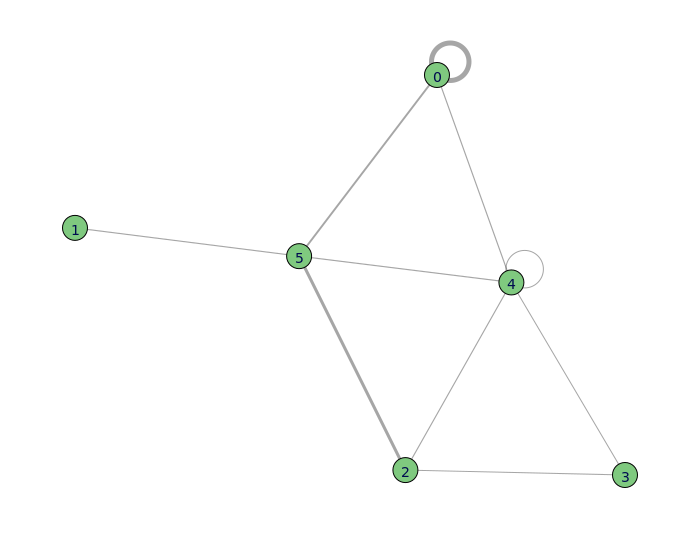

### 5

{'vertex_size': 25, 'vertex_color': 'rgb(127, 201, 127)', 'vertex_label_color': 'rgb(0, 11, 79)', 'edge_color': 'rgb(0.2, 0.2, 0.2, 0.35)', 'nodeLabels': [0, 1, 2, 3, 4, 5], 'edge_width': [2.7863674584122293, 3.3970874206857657, 4.443358289531945, 1.6199165347695021, 5.0, 2.7863674584122293, 4.443358289531945]}


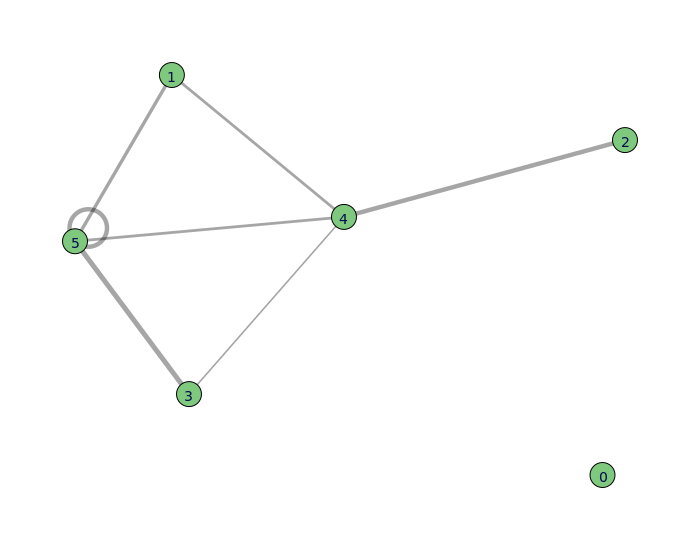

### 6

{'vertex_size': 25, 'vertex_color': 'rgb(127, 201, 127)', 'vertex_label_color': 'rgb(0, 11, 79)', 'edge_color': 'rgb(0.2, 0.2, 0.2, 0.35)', 'nodeLabels': [0, 1, 2, 3, 4, 5], 'edge_width': [1.273293208541913, 1.064120823990455, 1.064120823990455, 5.0, 3.530191706681172]}


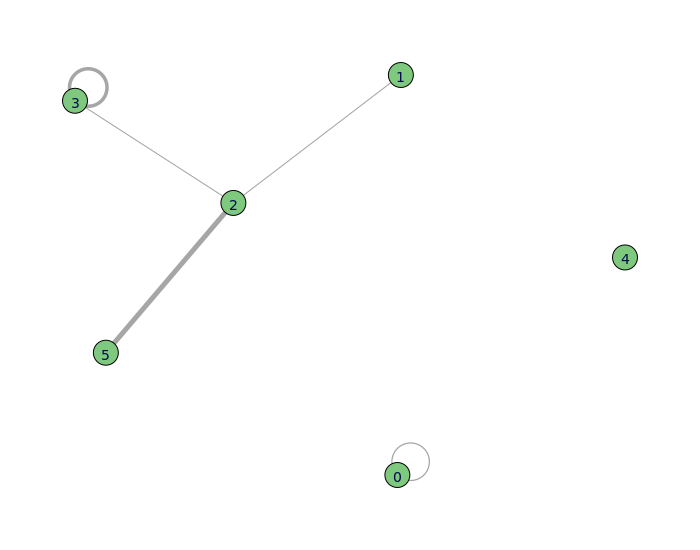

### 7

{'vertex_size': 25, 'vertex_color': 'rgb(127, 201, 127)', 'vertex_label_color': 'rgb(0, 11, 79)', 'edge_color': 'rgb(0.2, 0.2, 0.2, 0.35)', 'nodeLabels': [0, 1, 2, 3, 4, 5], 'edge_width': [2.1563301363265976, 2.429124582091244, 5.0, 2.458590812134067, 1.244432530488146, 1.4329114443509934, 2.1563301363265976, 2.458590812134067, 1.0946176049288132, 1.07503692573625, 1.7354197423837867]}


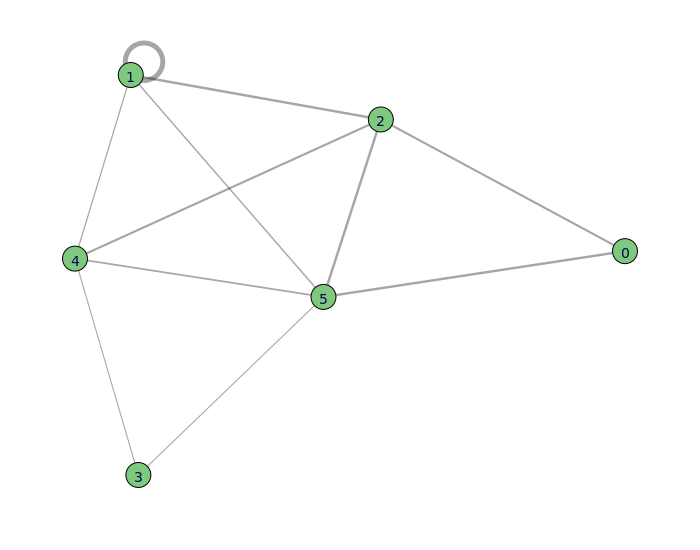

### 8

{'vertex_size': 25, 'vertex_color': 'rgb(127, 201, 127)', 'vertex_label_color': 'rgb(0, 11, 79)', 'edge_color': 'rgb(0.2, 0.2, 0.2, 0.35)', 'nodeLabels': [0, 1, 2, 3, 4, 5], 'edge_width': [4.1307461248130775, 1.441156064954728, 1.0333523979628596, 1.5051076567315689, 5.0, 4.1307461248130775, 1.441156064954728]}


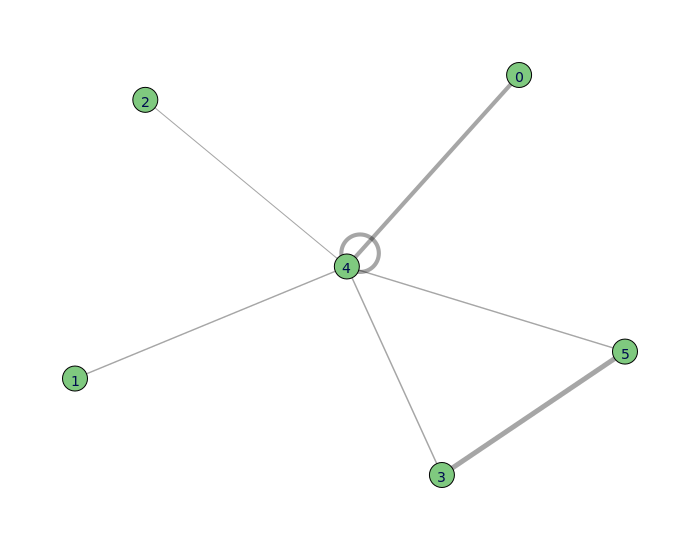

In [89]:
explVar = 0
for i in range(pca.explained_variance_ratio_.size):
    explVar += pca.explained_variance_ratio_[i]
    if explVar > 0.9:
        break
    mdisp(f"### {i}")
    adjmat = vec2squareMat(pca.components_[:,i]) 
    adjmat[adjmat < 1e-4] = 0.0
    tmp = nx.from_numpy_matrix(adjmat)
    draw = igdraw(tmp, nodeLabels=True)
    disp(draw)

In [90]:
import ipywidgets as iw

In [93]:
@iw.interact(cut=(0, 7**2-1, 1), idx=(0, 12, 1))
def f(cut, idx):
    layout = [[3.9877742567859795, 0.10108983249875346],
              [1.9096174697926602, 1.1890965748231208],
              [2.397807521611018, -0.9264800307227699],
              [1.3709208650198719, -0.18028506977491185],
              [3.156617539889597, 1.0547733043844556],
              [3.0469455647068235, -0.041477634452122915],
              [3.6688653065045, -0.7492428253653193]]
    adjmat = vec2squareMat(pca.components_[:, idx])
    val = np.sort(pca.components_[:, 0])[::-1]
    au = adjmat.copy()
    au[au<val[cut]] = 0
    # print(au)
    g = nx.from_numpy_matrix(au, create_using=nx.DiGraph())
    dr = igdraw(g, layout=layout, nodeLabels=True)
    return dr

interactive(children=(IntSlider(value=24, description='cut', max=48), IntSlider(value=6, description='idx', max=12), Output()), _dom_classes=('widget-interact',))

In [94]:
adjmat = vec2squareMat(pca.components_[:, 0])

# Apply clustering algorithms

In [95]:
from sklearn import cluster

In [96]:
kmeans = cluster.KMeans(max_iter=1000, n_jobs=16, n_clusters=8) 

In [97]:
clstData = standardizeData(pca.components_.T) 

In [98]:
kmeans.fit(clstData)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=8, n_init=10, n_jobs=16, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [99]:
clst = kmeans.fit_predict(clstData)

In [100]:
np.unique(clst, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([1573,    2,    1,    1,  143,    1,    1,   19]))

DBSCAN could be interesting

In [101]:
dbscan = cluster.DBSCAN(n_jobs=16)
dbscan.fit(clstData)
clst = dbscan.fit_predict(clstData)

In [102]:
np.unique(clst, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([ 281, 1133,   17,    6,   29,    5,   51,   37,   15,   54,    6,    9,   25,    5,   17,   10,    6,    9,    6,    8,   12]))

In [103]:
clstData.shape

(1741, 36)

… and HDBSCAN as well

In [104]:
from hdbscan import HDBSCAN

In [105]:
hdbscan = HDBSCAN(min_cluster_size=40, p=1, core_dist_n_jobs=16) 
hdbscanClst_p1 = hdbscan.fit_predict(clstData)
np.unique(hdbscanClst_p1, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([ 399,   43, 1136,   73,   90]))

In [110]:
hdbscan = HDBSCAN(min_cluster_size=20, p=2, core_dist_n_jobs=16) 
hdbscanClst_p2 = hdbscan.fit_predict(clstData)
np.unique(hdbscanClst_p2, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]),
 array([ 325,   44,   41,   36, 1136,   51,   21,   66,   21]))

Spectral clustering could be interesting

In [ ]:
n = 600
specClust = cluster.SpectralClustering(n_jobs=16, n_clusters=4) 
specClust.fit(clstData[:n, :])
clst = specClust.fit_predict(clstData[:n, :])

In [ ]:
np.unique(clst, return_counts=True)

In [ ]:
agglo = cluster.AgglomerativeClustering(n_clusters=4)
agglo.fit(clstData)
clst = agglo.fit_predict(clstData)
np.unique(clst, return_counts=True)

t-sne

In [112]:
from sklearn import manifold

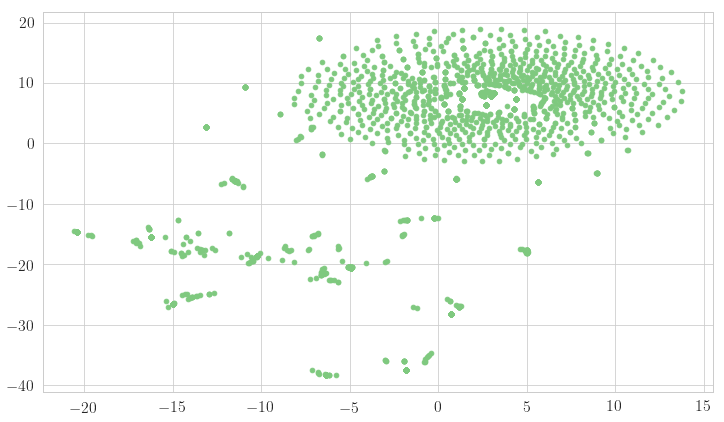

In [124]:
tsne = manifold.TSNE(perplexity=30)

clst = tsne.fit_transform(clstData)

fig, ax = plt.subplots()
ax.scatter(*clst.T)

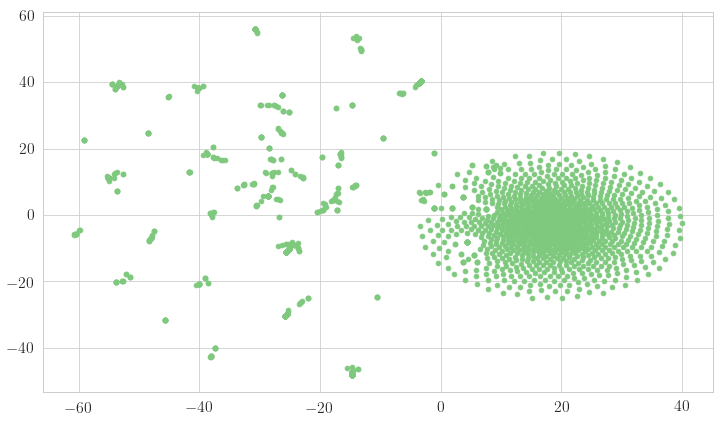

In [125]:
tsne = manifold.TSNE(perplexity=4)

clst = tsne.fit_transform(clstData)

fig, ax = plt.subplots()
ax.scatter(*clst.T)

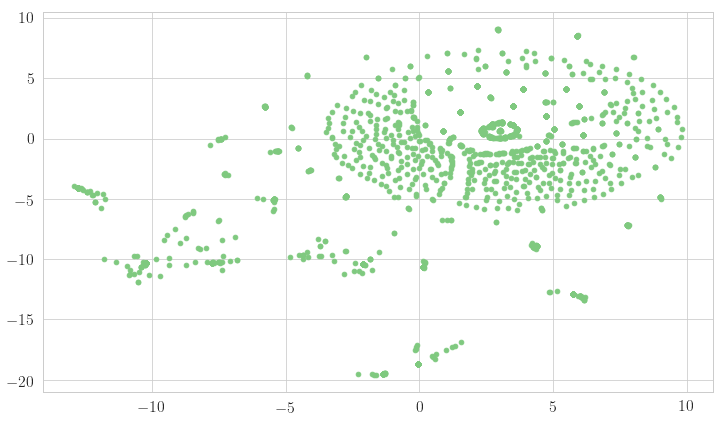

In [126]:
tsne = manifold.TSNE(perplexity=75)

clst = tsne.fit_transform(clstData)

fig, ax = plt.subplots()
ax.scatter(*clst.T)